In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
import networkx as nx

# Extract values from matrix; this is QUBO specific, but the rest of the code can take nonquadratic functions as well.

In [2]:
def qubo_values(QuadraticForm):
    confs = (jnp.arange(1 << QuadraticForm.shape[0]).reshape(-1, 1) >> jnp.arange(QuadraticForm.shape[0]))%2
    return jnp.sum((confs@QuadraticForm) * confs, axis=1)

In [3]:
def fpgas_updater(p, delta, l, p0, cdf_inv):
    #cdf_inv = 1 - np.cumsum(p0)
    inner_chebishevs = np.cosh(np.arccosh(1 / delta) / (2 * l + 1)) * np.sqrt(1 - cdf_inv)

    P_failures = np.square(np.where(inner_chebishevs <= 1, np.cos(np.arccos(np.minimum(inner_chebishevs, 1)) * (2 * l + 1)), np.cosh(np.arccosh(np.maximum(inner_chebishevs, 1)) * (2 * l + 1))) * delta)

    p_new = p * P_failures
    p_new[1:] += np.cumsum(p[:-1] * (1 - P_failures[:-1]) / cdf_inv[:-1]) * p0[1:]

    p_new = p_new / np.sum(p_new) # stabilization

    return p_new

In [4]:
def gas_updater(p, m, p0, cdf_inv):
    #cdf_inv = 1 - np.cumsum(p0)
    thetas = 2 * np.arcsin(np.sqrt(cdf_inv)) / np.pi

    P_failures = (1 + np.sinc(2 * m * thetas) / np.sinc(thetas)) / 2

    p_new = p * P_failures
    p_new[1:] += np.cumsum(p[:-1] * (1 - P_failures[:-1]) / cdf_inv[:-1]) * p0[1:]

    p_new = p_new / np.sum(p_new) # stabilization

    return p_new

# graph to generate QUBO for testing

In [23]:
# random, connected graph
NumberOfVertices, EdgeProbability = 27, 5e-1
Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
#while not nx.is_connected(Graph):
#    Graph = nx.erdos_renyi_graph(NumberOfVertices, EdgeProbability)
#nx.draw(Graph, with_labels=False)
GraphLaplacian = jnp.array(nx.laplacian_matrix(Graph).toarray())
NumberOfEdges = jnp.trace(GraphLaplacian) >> 1

# let's get rid of the vertex with the highest degree; this step is not necessary, but saves one bit
maxdegvertex = jnp.argmax(jnp.diag(GraphLaplacian))
Q = jnp.delete(jnp.delete(GraphLaplacian, maxdegvertex, 0), maxdegvertex, 1)

In [24]:
cuts = qubo_values(Q)
cut_values, p0 = jnp.unique(cuts, return_counts=True)
MaxCut, p0 = cut_values[-1],  p0 / (1 << Q.shape[0])

# simulation

In [71]:
rounds = 5 # number of iterations to run

In [72]:
Lambda = 6/5 # paramaters for GAS; Lambda = 6/5 is from Boyer et al.

In [88]:
delta, alpha = 0.5, 6/5 # 0.4038, 1.975 # paramaters for FPGAS / far from optimal at such a low qubit number

In [89]:
cdf_inv = 1 - np.cumsum(p0)

In [93]:
# runing the simulation
p_gas = np.copy(p0)
m = 1
for idx in range(rounds):
    p_gas = gas_updater(p_gas, np.ceil(m), p0, cdf_inv)
    m *= Lambda

In [94]:
# runing the simulation
p_fpgas = np.copy(p0)
l = 1
for idx in range(rounds):
    p_fpgas = fpgas_updater(p_fpgas, delta, np.ceil(l), p0, cdf_inv)
    l *= alpha

# statistics

In [95]:
E_random = np.dot(p0, cut_values)
E_gas = np.dot(p_gas, cut_values)
E_fpgas = np.dot(p_fpgas, cut_values)

cut_values_squared = np.square(cut_values)

sigma_random = np.sqrt(np.dot(p0, cut_values_squared) - E_random**2)
sigma_gas = np.sqrt(np.dot(p_gas, cut_values_squared) - E_gas**2)
sigma_fpgas = np.sqrt(np.dot(p_fpgas, cut_values_squared) - E_fpgas**2)

print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t----------------------")
print(f"\t\trandom\tGAS\tFPGAS\n")
print(f"E[cut]\t\t{(E_random / MaxCut):.2%}\t{(E_gas / MaxCut):.2%}\t{(E_fpgas / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_random / MaxCut):.2%}\t{(sigma_gas / MaxCut):.2%}\t{(sigma_fpgas / MaxCut):.2%}")

		maximal cut	= 118
		----------------------
		random	GAS	FPGAS

E[cut]		79.24%	87.19%	89.67%
D[cut]		5.79%	3.28%	2.16%


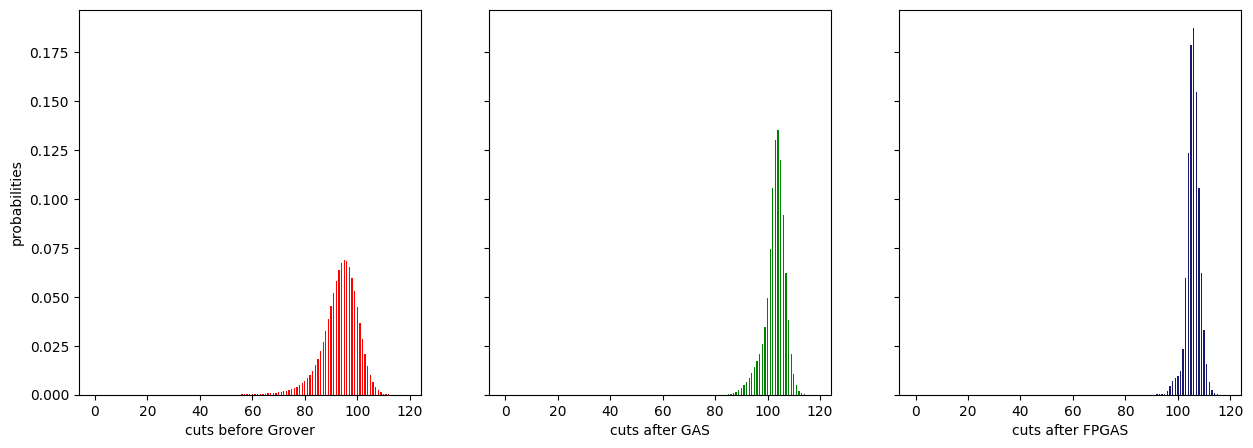

In [96]:
fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

axs[0].bar(cut_values,
           p0,
           width=0.5,
           color="red")
axs[0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")

axs[1].bar(cut_values,
           p_gas,
           width=0.5,
           color="green")
axs[1].set(xlabel=f"cuts after GAS")

axs[2].bar(cut_values,
           p_fpgas,
           width=0.5,
           color="midnightblue")
axs[2].set(xlabel=f"cuts after FPGAS")

plt.show()

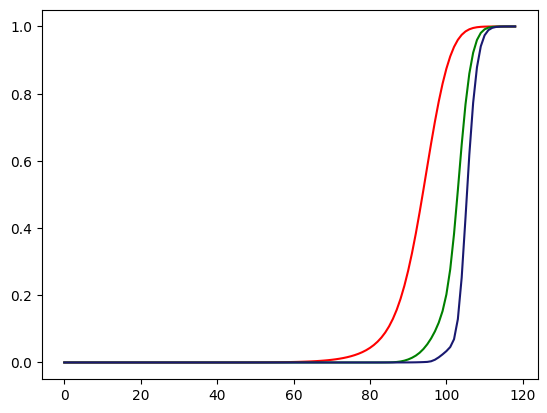

In [97]:
cdf_0 = np.cumsum(p0)
cdf_gas = np.cumsum(p_gas)
cdf_fpgas = np.cumsum(p_fpgas)

plt.plot(cut_values, cdf_0, 'red')
plt.plot(cut_values, cdf_gas, 'green')
plt.plot(cut_values, cdf_fpgas, 'midnightblue')
plt.show()

# probabilities of finding MaxCut

In [43]:
print(f"{p0[-1]:.4%}\t{p_gas[-1]:.4%}\t{p_fpgas[-1]:.4%}\t{p_nbqaa[-1]:.4%}")

0.0002%	0.0022%	0.0190%	0.0022%


# improvemnts

In [44]:
p_fpgas[-1] / p0[-1], p_fpgas[-1] / p_gas[-1]

(Array(99.42682, dtype=float32), np.float64(8.761514668469127))

# with repetition

In [45]:
def repeater(distribution, r):
    CDF = np.power(np.cumsum(distribution), r)
    distribution_new = CDF - np.roll(CDF, 1)
    distribution_new[0] = CDF[0]
    return distribution_new    

In [46]:
reps = NumberOfVertices**2

In [47]:
# cut statistics
p0_with_reps = repeater(p0, reps)
p_gas_with_reps = repeater(p_gas, reps)
p_fpgas_with_reps = repeater(p_fpgas, reps)
p_nbqaa_with_reps = repeater(p_nbqaa, reps)

In [48]:
E_random_with_reps = np.dot(p0_with_reps, cut_values)
E_gas_with_reps = np.dot(p_gas_with_reps, cut_values)
E_fpgas_with_reps = np.dot(p_fpgas_with_reps, cut_values)
E_nbqaa_with_reps = np.dot(p_nbqaa_with_reps, cut_values)

sigma_random_with_reps = np.sqrt(np.dot(p0_with_reps, cut_values_squared) - E_random_with_reps**2)
sigma_gas_with_reps = np.sqrt(np.dot(p_gas_with_reps, cut_values_squared) - E_gas_with_reps**2)
sigma_fpgas_with_reps = np.sqrt(np.dot(p_fpgas_with_reps, cut_values_squared) - E_fpgas_with_reps**2)
sigma_nbqaa_with_reps = np.sqrt(np.dot(p_nbqaa_with_reps, cut_values_squared) - E_nbqaa_with_reps**2)

In [49]:
print(f"\t\tmaximal cut\t= {MaxCut}\n\t\t------------------------------")
print(f"\t\tnumber of reps\t= {reps}\n\t\t------------------------------")
print(f"\t\trandom\tGAS\tFPGAS\tNBQAA\n")
print(f"E[cut]\t\t{(E_random_with_reps / MaxCut):.2%}\t{(E_gas_with_reps / MaxCut):.2%}\t{(E_fpgas_with_reps / MaxCut):.2%}\t{(E_nbqaa_with_reps / MaxCut):.2%}")
print(f"D[cut]\t\t{(sigma_random_with_reps / MaxCut):.2%}\t{(sigma_gas_with_reps / MaxCut):.2%}\t{(sigma_fpgas_with_reps / MaxCut):.2%}\t{(sigma_nbqaa_with_reps / MaxCut):.2%}")

		maximal cut	= 62
		------------------------------
		number of reps	= 400
		------------------------------
		random	GAS	FPGAS	NBQAA

E[cut]		93.17%	96.19%	98.06%	96.22%
D[cut]		1.81%	1.27%	0.90%	1.27%


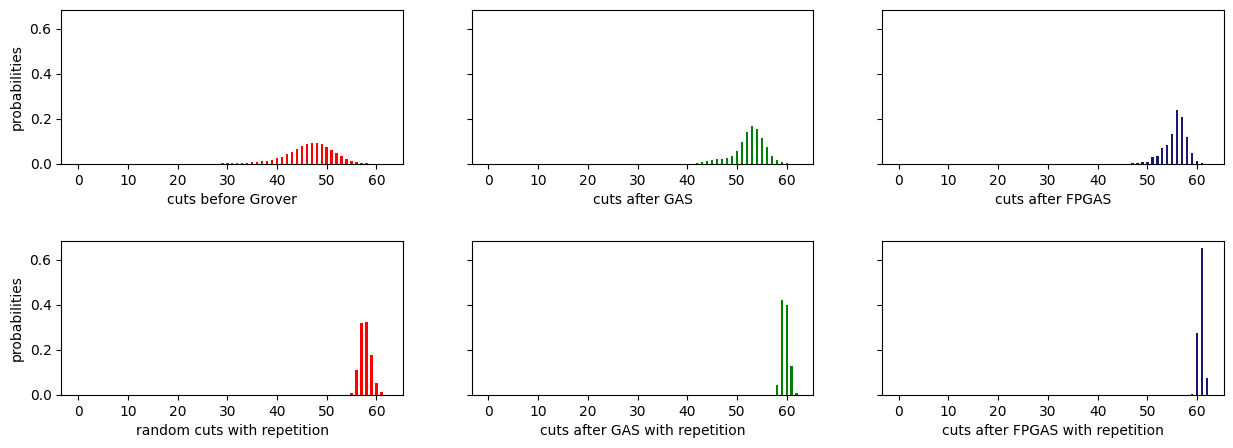

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(15, 5))

axs[0, 0].bar(cut_values,
           p0,
           width=0.5,
           color="red")
axs[0, 0].set(xlabel=f"cuts before Grover",
           ylabel=f"probabilities")

axs[0, 1].bar(cut_values,
           p_gas,
           width=0.5,
           color="green")
axs[0, 1].set(xlabel=f"cuts after GAS")

axs[0, 2].bar(cut_values,
           p_fpgas,
           width=0.5,
           color="midnightblue")
axs[0, 2].set(xlabel=f"cuts after FPGAS")

axs[1, 0].bar(cut_values,
           p0_with_reps,
           width=0.5,
           color="red")
axs[1, 0].set(xlabel=f"random cuts with repetition",
           ylabel=f"probabilities")

axs[1, 1].bar(cut_values,
           p_gas_with_reps,
           width=0.5,
           color="green")
axs[1, 1].set(xlabel=f"cuts after GAS with repetition")

axs[1, 2].bar(cut_values,
           p_fpgas_with_reps,
           width=0.5,
           color="midnightblue")
axs[1, 2].set(xlabel=f"cuts after FPGAS with repetition")

plt.subplots_adjust(hspace=0.5)

plt.show()

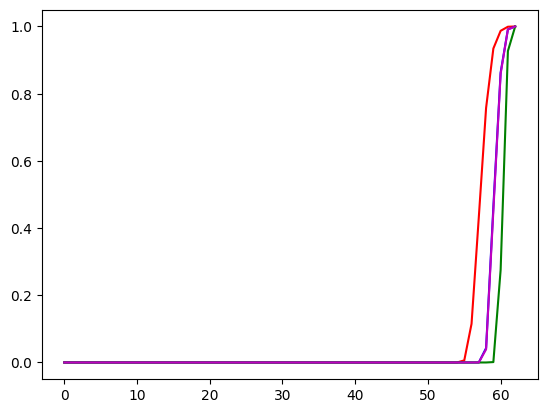

In [51]:
cdf_0_with_reps = np.cumsum(p0_with_reps)
cdf_gas_with_reps = np.cumsum(p_gas_with_reps)
cdf_fpgas_with_reps = np.cumsum(p_fpgas_with_reps)
cdf_nbqaa_with_reps = np.cumsum(p_nbqaa_with_reps)

plt.plot(cut_values, cdf_0_with_reps, 'r')
plt.plot(cut_values, cdf_gas_with_reps, 'b')
plt.plot(cut_values, cdf_fpgas_with_reps, 'g')
plt.plot(cut_values, cdf_nbqaa_with_reps, 'm')
plt.show()